# Irrigation Control Model Comparison
## Finding the Best Model Family for Edge Deployment

**Objective**: Compare lightweight ML models to find the best balance of:
- **Accuracy**: High predictive performance
- **Interpretability**: Explainable decisions for farmers
- **Edge-friendliness**: Low memory, fast inference on Pi 4B

**Models to Compare**:
1. **DecisionTreeClassifier** - Interpretable, fast, low memory
2. **RandomForestClassifier** - Ensemble power, feature importance
3. **LogisticRegression** - Simple baseline, probabilistic output

**Evaluation Strategy**:
- Stratified evaluation (handles class imbalance)
- Metrics: Accuracy, Precision, Recall, F1-score (macro + per-class)
- Confusion matrices
- Feature importance analysis
- Class weighting if needed

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import pickle
from datetime import datetime
import time
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn imports
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, ConfusionMatrixDisplay
)
from sklearn.model_selection import cross_val_score, StratifiedKFold
from imblearn.over_sampling import SMOTE
from collections import Counter

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Project paths
PROJECT_DIR = Path('/home/tehaan/projects/fyp-agro-edge-ai')
DATA_PROCESSED = PROJECT_DIR / 'data' / 'processed' / 'irrigation'
MODELS_DIR = PROJECT_DIR / 'models'
LOGS_DIR = PROJECT_DIR / 'logs' / 'irrigation_control'
MODELS_DIR.mkdir(parents=True, exist_ok=True)
LOGS_DIR.mkdir(parents=True, exist_ok=True)

# Random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print(f"✓ Imports successful")
print(f"✓ Models directory: {MODELS_DIR}")
print(f"✓ Logs directory: {LOGS_DIR}")

✓ Imports successful
✓ Models directory: /home/tehaan/projects/fyp-agro-edge-ai/models
✓ Logs directory: /home/tehaan/projects/fyp-agro-edge-ai/logs/irrigation_control


## 1. Load Preprocessed Data

In [10]:
# Load flat data (for traditional ML models)
print("Loading preprocessed data...\n")

X_train = np.load(DATA_PROCESSED / 'X_train_flat.npy')
X_test = np.load(DATA_PROCESSED / 'X_test_flat.npy')
y_train = np.load(DATA_PROCESSED / 'y_train.npy')
y_test = np.load(DATA_PROCESSED / 'y_test.npy')

print(f"✓ Data loaded successfully")
print(f"\nTrain set:")
print(f"  X_train shape: {X_train.shape}")
print(f"  y_train shape: {y_train.shape}")
print(f"\nTest set:")
print(f"  X_test shape: {X_test.shape}")
print(f"  y_test shape: {y_test.shape}")

# Load feature names
with open(DATA_PROCESSED / 'feature_names.json', 'r') as f:
    feature_names = json.load(f)

print(f"\n✓ Loaded {len(feature_names)} feature names")

# Load preprocessing metadata
with open(DATA_PROCESSED / 'preprocessing_metadata.json', 'r') as f:
    preprocessing_metadata = json.load(f)

print(f"✓ Loaded preprocessing metadata")

Loading preprocessed data...

✓ Data loaded successfully

Train set:
  X_train shape: (7004, 222)
  y_train shape: (7004,)

Test set:
  X_test shape: (1752, 222)
  y_test shape: (1752,)

✓ Loaded 37 feature names
✓ Loaded preprocessing metadata


## 2. Exploratory Analysis: Class Distribution

CLASS DISTRIBUTION ANALYSIS

Class distribution:


,Train_Count,Train_Pct,Test_Count,Test_Pct
Irrigate_High,206,2.94,61,3.48
Irrigate_Low,510,7.28,137,7.82
No_Irrigation,6288,89.78,1554,88.70



Imbalance ratio: 30.52
⚠ Significant class imbalance detected!
  → Will use class weighting and/or SMOTE


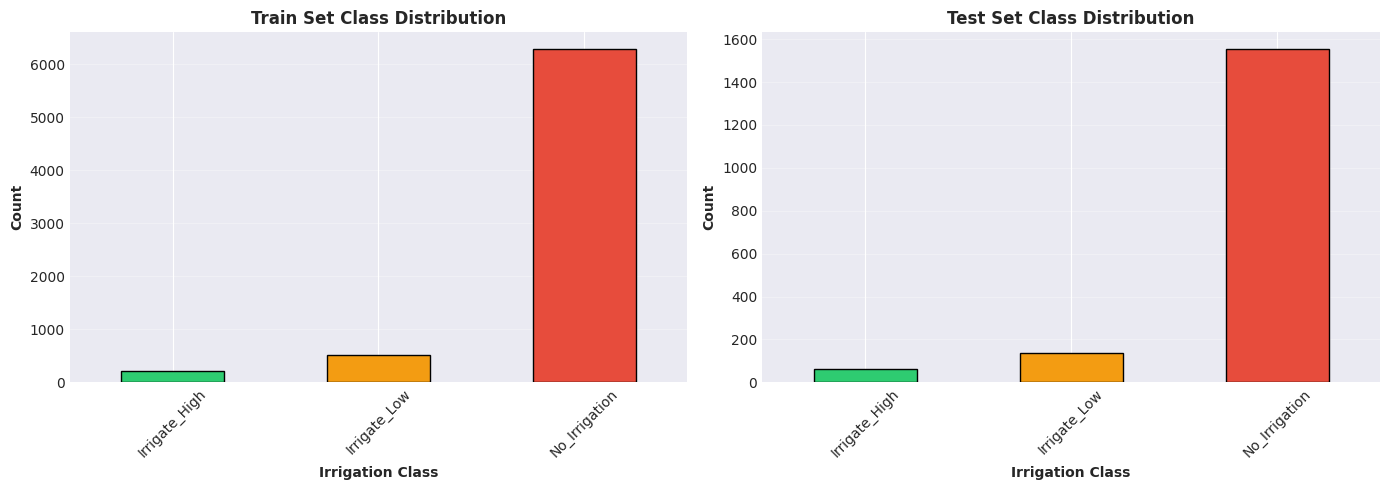


📊 Class distribution plots generated


In [11]:
# Analyze class distribution
print("="*80)
print("CLASS DISTRIBUTION ANALYSIS")
print("="*80)

train_class_counts = pd.Series(y_train).value_counts().sort_index()
test_class_counts = pd.Series(y_test).value_counts().sort_index()

class_dist_df = pd.DataFrame({
    'Train_Count': train_class_counts,
    'Train_Pct': (train_class_counts / len(y_train) * 100).round(2),
    'Test_Count': test_class_counts,
    'Test_Pct': (test_class_counts / len(y_test) * 100).round(2)
})

print("\nClass distribution:")
display(class_dist_df)

# Check for class imbalance
imbalance_ratio = train_class_counts.max() / train_class_counts.min()
print(f"\nImbalance ratio: {imbalance_ratio:.2f}")

if imbalance_ratio > 3:
    print("⚠ Significant class imbalance detected!")
    print("  → Will use class weighting and/or SMOTE")
else:
    print("✓ Class distribution is reasonably balanced")

# Visualize distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Train distribution
train_class_counts.plot(kind='bar', ax=axes[0], color=['#2ecc71', '#f39c12', '#e74c3c'], edgecolor='black')
axes[0].set_title('Train Set Class Distribution', fontweight='bold', fontsize=12)
axes[0].set_xlabel('Irrigation Class', fontweight='bold')
axes[0].set_ylabel('Count', fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].tick_params(axis='x', rotation=45)

# Test distribution
test_class_counts.plot(kind='bar', ax=axes[1], color=['#2ecc71', '#f39c12', '#e74c3c'], edgecolor='black')
axes[1].set_title('Test Set Class Distribution', fontweight='bold', fontsize=12)
axes[1].set_xlabel('Irrigation Class', fontweight='bold')
axes[1].set_ylabel('Count', fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n📊 Class distribution plots generated")

## 3. Handle Class Imbalance (If Needed)

### Strategy:
1. **Class weighting**: Penalize misclassifications of minority classes
2. **SMOTE (optional)**: Synthetic oversampling if imbalance is severe (ratio > 5)

We'll train models both with and without SMOTE and compare.

In [12]:
# Decision: Apply SMOTE if imbalance ratio > 5
USE_SMOTE = imbalance_ratio > 5

if USE_SMOTE:
    print("Applying SMOTE to balance classes...\n")
    
    smote = SMOTE(random_state=RANDOM_STATE)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    
    print(f"Original train set: {X_train.shape[0]} samples")
    print(f"SMOTE train set: {X_train_smote.shape[0]} samples")
    print(f"\nClass distribution after SMOTE:")
    print(pd.Series(y_train_smote).value_counts().sort_index())
    
    # We'll compare models with/without SMOTE
    X_train_versions = {'Original': X_train, 'SMOTE': X_train_smote}
    y_train_versions = {'Original': y_train, 'SMOTE': y_train_smote}
else:
    print("Class balance is acceptable. Using class weighting only.\n")
    X_train_versions = {'Original': X_train}
    y_train_versions = {'Original': y_train}

Applying SMOTE to balance classes...

Original train set: 7004 samples
SMOTE train set: 18864 samples

Class distribution after SMOTE:
Irrigate_High    6288
Irrigate_Low     6288
No_Irrigation    6288
Name: count, dtype: int64


## 4. Model Training & Evaluation

### Models to Train:
1. **DecisionTreeClassifier**
   - Max depth: 10, 15, 20, None
   - Min samples split: 2, 5, 10
   - Criterion: gini, entropy

2. **RandomForestClassifier**
   - N estimators: 50, 100, 200
   - Max depth: 10, 15, 20
   - Min samples split: 2, 5

3. **LogisticRegression**
   - C: 0.1, 1.0, 10.0
   - Solver: lbfgs, liblinear
   - Max iter: 1000

We'll use **stratified cross-validation** for robust evaluation.

In [13]:
# Helper function for model evaluation
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """
    Train and evaluate a model with comprehensive metrics.
    """
    print(f"\n{'='*80}")
    print(f"Training: {model_name}")
    print(f"{'='*80}")
    
    # Train model
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Inference time (average per sample)
    inference_start = time.time()
    _ = model.predict(X_test[:100])
    inference_time = (time.time() - inference_start) / 100 * 1000  # ms per sample
    
    # Metrics
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test, average='macro', zero_division=0)
    test_recall = recall_score(y_test, y_pred_test, average='macro', zero_division=0)
    test_f1 = f1_score(y_test, y_pred_test, average='macro', zero_division=0)
    
    # Per-class metrics
    test_precision_per_class = precision_score(y_test, y_pred_test, average=None, zero_division=0)
    test_recall_per_class = recall_score(y_test, y_pred_test, average=None, zero_division=0)
    test_f1_per_class = f1_score(y_test, y_pred_test, average=None, zero_division=0)
    
    # Stratified cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    
    print(f"\n✓ Training complete in {train_time:.2f}s")
    print(f"\nPerformance Metrics:")
    print(f"  Train Accuracy: {train_acc*100:.2f}%")
    print(f"  Test Accuracy:  {test_acc*100:.2f}%")
    print(f"  Test Precision (macro): {test_precision*100:.2f}%")
    print(f"  Test Recall (macro):    {test_recall*100:.2f}%")
    print(f"  Test F1-score (macro):  {test_f1*100:.2f}%")
    print(f"\nCross-Validation (5-fold):")
    print(f"  CV Accuracy: {cv_scores.mean()*100:.2f}% ± {cv_scores.std()*100:.2f}%")
    print(f"\nInference Time:")
    print(f"  {inference_time:.4f} ms per sample")
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_test)
    
    # Classification report
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred_test, zero_division=0))
    
    # Return results dictionary
    classes = np.unique(y_test)
    results = {
        'model_name': model_name,
        'train_time': train_time,
        'inference_time_ms': inference_time,
        'train_accuracy': train_acc,
        'test_accuracy': test_acc,
        'test_precision_macro': test_precision,
        'test_recall_macro': test_recall,
        'test_f1_macro': test_f1,
        'cv_accuracy_mean': cv_scores.mean(),
        'cv_accuracy_std': cv_scores.std(),
        'confusion_matrix': cm.tolist(),
        'per_class_metrics': {
            str(classes[i]): {
                'precision': float(test_precision_per_class[i]),
                'recall': float(test_recall_per_class[i]),
                'f1_score': float(test_f1_per_class[i])
            } for i in range(len(classes))
        },
        'model': model
    }
    
    return results

print("✓ Evaluation function ready")

✓ Evaluation function ready


### 4.1. Decision Tree Classifier

In [14]:
# Decision Tree with hyperparameter tuning
dt_configs = [
    {'max_depth': 10, 'min_samples_split': 5, 'criterion': 'gini'},
    {'max_depth': 15, 'min_samples_split': 5, 'criterion': 'gini'},
    {'max_depth': 20, 'min_samples_split': 2, 'criterion': 'entropy'},
    {'max_depth': None, 'min_samples_split': 10, 'criterion': 'gini'},
]

dt_results = []

for idx, config in enumerate(dt_configs):
    for data_version in X_train_versions.keys():
        model = DecisionTreeClassifier(
            max_depth=config['max_depth'],
            min_samples_split=config['min_samples_split'],
            criterion=config['criterion'],
            random_state=RANDOM_STATE,
            class_weight='balanced'
        )
        
        model_name = f"DecisionTree_{data_version}_Config{idx+1}"
        results = evaluate_model(
            model, 
            X_train_versions[data_version], 
            y_train_versions[data_version],
            X_test, 
            y_test, 
            model_name
        )
        results['config'] = config
        results['data_version'] = data_version
        dt_results.append(results)

print(f"\n✓ Trained {len(dt_results)} DecisionTree variants")


Training: DecisionTree_Original_Config1

✓ Training complete in 0.31s

Performance Metrics:
  Train Accuracy: 100.00%
  Test Accuracy:  100.00%
  Test Precision (macro): 100.00%
  Test Recall (macro):    100.00%
  Test F1-score (macro):  100.00%

Cross-Validation (5-fold):
  CV Accuracy: 99.90% ± 0.03%

Inference Time:
  0.0016 ms per sample

Classification Report:
               precision    recall  f1-score   support

Irrigate_High       1.00      1.00      1.00        61
 Irrigate_Low       1.00      1.00      1.00       137
No_Irrigation       1.00      1.00      1.00      1554

     accuracy                           1.00      1752
    macro avg       1.00      1.00      1.00      1752
 weighted avg       1.00      1.00      1.00      1752


Training: DecisionTree_SMOTE_Config1

✓ Training complete in 3.26s

Performance Metrics:
  Train Accuracy: 98.84%
  Test Accuracy:  97.72%
  Test Precision (macro): 91.03%
  Test Recall (macro):    94.80%
  Test F1-score (macro):  92.52%

Cro

### 4.2. Random Forest Classifier

In [15]:
# Random Forest with hyperparameter tuning
rf_configs = [
    {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 5},
    {'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2},
    {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 2},
]

rf_results = []

for idx, config in enumerate(rf_configs):
    for data_version in X_train_versions.keys():
        model = RandomForestClassifier(
            n_estimators=config['n_estimators'],
            max_depth=config['max_depth'],
            min_samples_split=config['min_samples_split'],
            random_state=RANDOM_STATE,
            class_weight='balanced',
            n_jobs=-1
        )
        
        model_name = f"RandomForest_{data_version}_Config{idx+1}"
        results = evaluate_model(
            model, 
            X_train_versions[data_version], 
            y_train_versions[data_version],
            X_test, 
            y_test, 
            model_name
        )
        results['config'] = config
        results['data_version'] = data_version
        rf_results.append(results)

print(f"\n✓ Trained {len(rf_results)} RandomForest variants")


Training: RandomForest_Original_Config1

✓ Training complete in 0.60s

Performance Metrics:
  Train Accuracy: 99.64%
  Test Accuracy:  97.89%
  Test Precision (macro): 91.51%
  Test Recall (macro):    93.09%
  Test F1-score (macro):  92.22%

Cross-Validation (5-fold):
  CV Accuracy: 97.43% ± 0.26%

Inference Time:
  0.1462 ms per sample

Classification Report:
               precision    recall  f1-score   support

Irrigate_High       0.92      0.89      0.90        61
 Irrigate_Low       0.83      0.92      0.88       137
No_Irrigation       1.00      0.99      0.99      1554

     accuracy                           0.98      1752
    macro avg       0.92      0.93      0.92      1752
 weighted avg       0.98      0.98      0.98      1752


Training: RandomForest_SMOTE_Config1

✓ Training complete in 2.39s

Performance Metrics:
  Train Accuracy: 98.34%
  Test Accuracy:  94.75%
  Test Precision (macro): 84.16%
  Test Recall (macro):    88.68%
  Test F1-score (macro):  85.02%

Cross-Va

### 4.3. Logistic Regression

In [16]:
# Logistic Regression with hyperparameter tuning
lr_configs = [
    {'C': 0.1, 'solver': 'lbfgs'},
    {'C': 1.0, 'solver': 'lbfgs'},
    {'C': 10.0, 'solver': 'saga'},  # saga supports multinomial
]

lr_results = []

for idx, config in enumerate(lr_configs):
    for data_version in X_train_versions.keys():
        # Determine multi_class based on solver
        multi_class = 'ovr' if config['solver'] == 'liblinear' else 'multinomial'
        
        model = LogisticRegression(
            C=config['C'],
            solver=config['solver'],
            max_iter=1000,
            random_state=RANDOM_STATE,
            class_weight='balanced',
            multi_class=multi_class
        )
        
        model_name = f"LogisticRegression_{data_version}_Config{idx+1}"
        results = evaluate_model(
            model, 
            X_train_versions[data_version], 
            y_train_versions[data_version],
            X_test, 
            y_test, 
            model_name
        )
        results['config'] = config
        results['data_version'] = data_version
        lr_results.append(results)

print(f"\n✓ Trained {len(lr_results)} LogisticRegression variants")


Training: LogisticRegression_Original_Config1

✓ Training complete in 16.70s

Performance Metrics:
  Train Accuracy: 94.17%
  Test Accuracy:  92.41%
  Test Precision (macro): 68.85%
  Test Recall (macro):    82.11%
  Test F1-score (macro):  74.14%

Cross-Validation (5-fold):
  CV Accuracy: 91.98% ± 0.85%

Inference Time:
  0.0026 ms per sample

Classification Report:
               precision    recall  f1-score   support

Irrigate_High       0.53      0.79      0.64        61
 Irrigate_Low       0.53      0.73      0.62       137
No_Irrigation       1.00      0.95      0.97      1554

     accuracy                           0.92      1752
    macro avg       0.69      0.82      0.74      1752
 weighted avg       0.94      0.92      0.93      1752


Training: LogisticRegression_SMOTE_Config1

✓ Training complete in 23.82s

Performance Metrics:
  Train Accuracy: 93.63%
  Test Accuracy:  93.09%
  Test Precision (macro): 69.08%
  Test Recall (macro):    79.91%
  Test F1-score (macro):  73

## 5. Model Comparison & Selection

In [17]:
# Combine all results
all_results = dt_results + rf_results + lr_results

# Create comparison dataframe
comparison_data = []
for result in all_results:
    comparison_data.append({
        'Model': result['model_name'],
        'Test_Accuracy': result['test_accuracy'] * 100,
        'Test_F1_Macro': result['test_f1_macro'] * 100,
        'Test_Precision': result['test_precision_macro'] * 100,
        'Test_Recall': result['test_recall_macro'] * 100,
        'CV_Accuracy': result['cv_accuracy_mean'] * 100,
        'Inference_Time_ms': result['inference_time_ms'],
        'Train_Time_s': result['train_time']
    })

comparison_df = pd.DataFrame(comparison_data).sort_values('Test_F1_Macro', ascending=False)

print("="*80)
print("MODEL COMPARISON (Sorted by Test F1-score)")
print("="*80)
display(comparison_df)

# Find best model
best_model_idx = comparison_df['Test_F1_Macro'].idxmax()
best_model_result = all_results[best_model_idx]

print(f"\n🏆 Best Model: {best_model_result['model_name']}")
print(f"   Test Accuracy: {best_model_result['test_accuracy']*100:.2f}%")
print(f"   Test F1-score: {best_model_result['test_f1_macro']*100:.2f}%")
print(f"   Inference Time: {best_model_result['inference_time_ms']:.4f} ms/sample")

MODEL COMPARISON (Sorted by Test F1-score)


,Model,Test_Accuracy,Test_F1_Macro,Test_Precision,Test_Recall,CV_Accuracy,Inference_Time_ms,Train_Time_s
0,DecisionTree_Original_Config1,100.000000,100.000000,100.000000,100.000000,99.900061,0.001595,0.314691
2,DecisionTree_Original_Config2,100.000000,100.000000,100.000000,100.000000,99.900061,0.001314,0.331167
6,DecisionTree_Original_Config4,100.000000,100.000000,100.000000,100.000000,99.900061,0.001593,0.389529
4,DecisionTree_Original_Config3,100.000000,100.000000,100.000000,100.000000,99.900061,0.001435,0.430317
1,DecisionTree_SMOTE_Config1,97.716895,92.521251,91.033138,94.801436,97.741722,0.001388,3.256999
8,RandomForest_Original_Config1,97.888128,92.220069,91.505059,93.090914,97.429979,0.146179,0.600545
3,DecisionTree_SMOTE_Config2,97.888128,90.635290,91.253968,91.190799,97.948465,0.001352,4.219166
5,DecisionTree_SMOTE_Config3,97.888128,89.951712,91.170635,90.140803,98.144594,0.001383,4.611033
11,RandomForest_SMOTE_Config2,96.575342,88.139462,88.313996,89.588154,98.892057,0.241740,6.015440
13,RandomForest_SMOTE_Config3,96.689498,87.142857,89.138141,87.309203,99.284336,0.505152,14.344651



🏆 Best Model: DecisionTree_Original_Config1
   Test Accuracy: 100.00%
   Test F1-score: 100.00%
   Inference Time: 0.0016 ms/sample


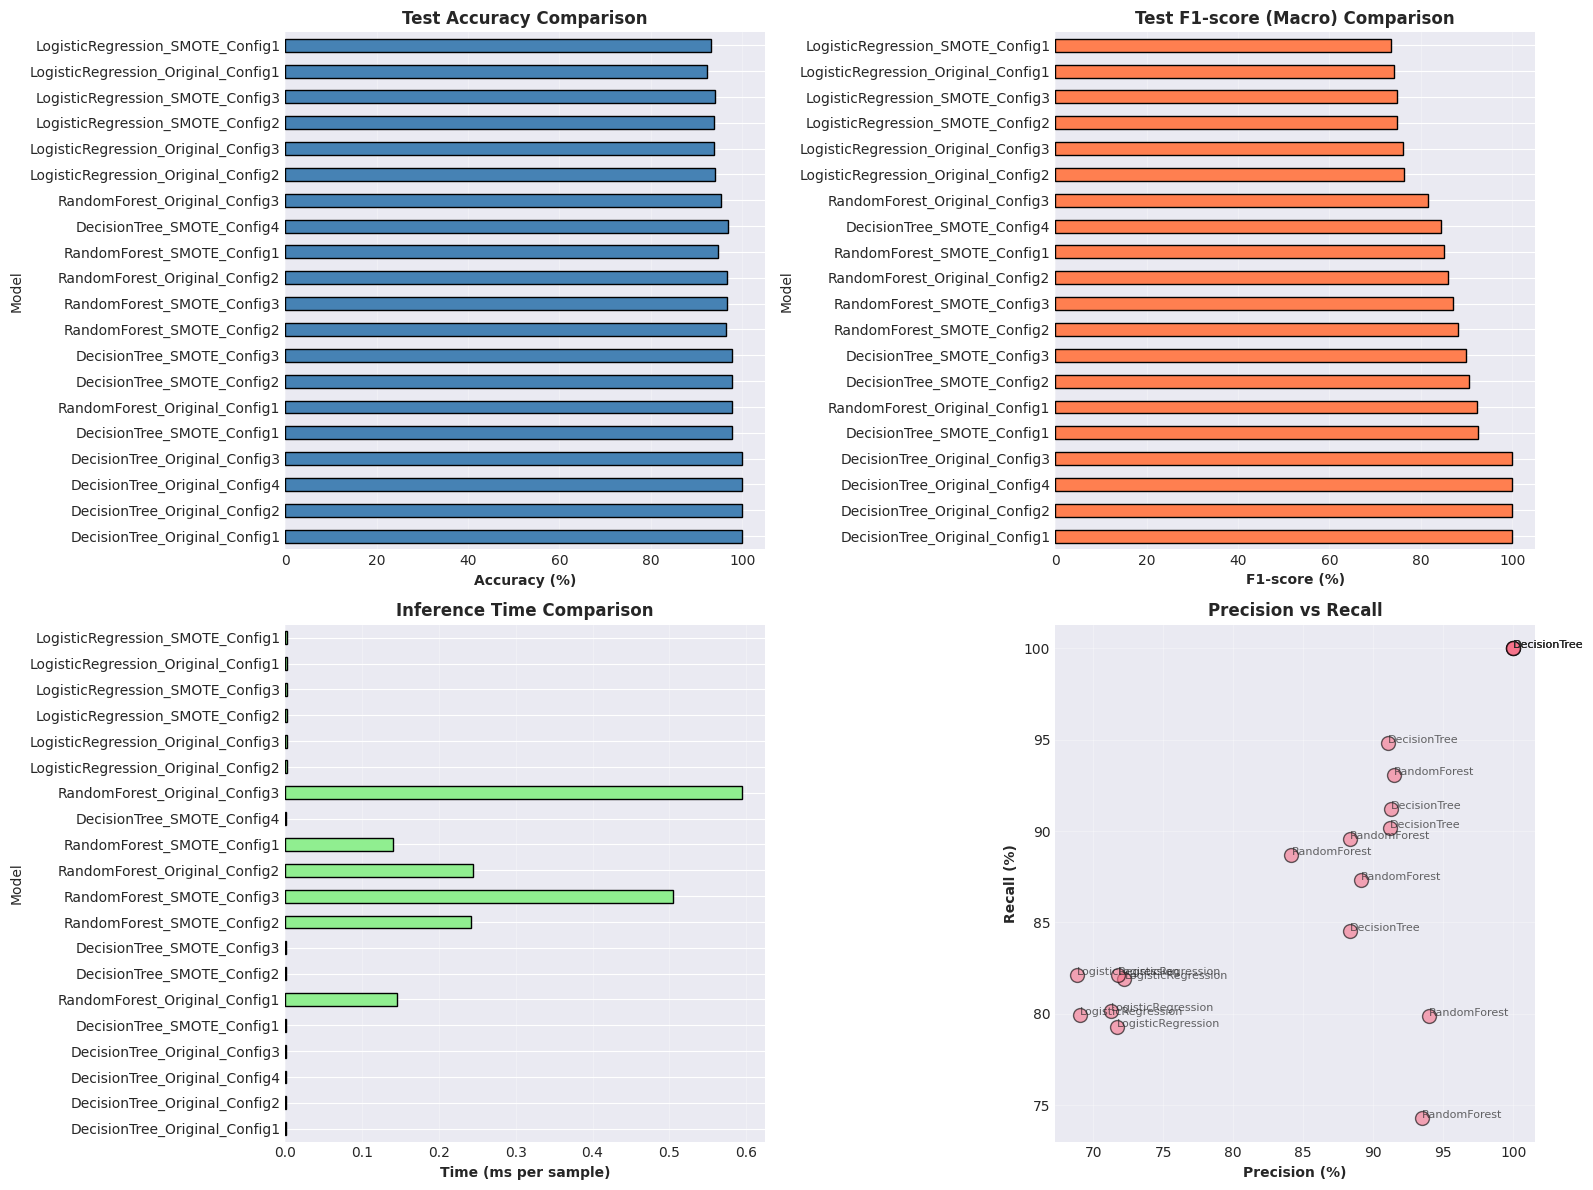


📊 Model comparison visualizations generated


In [18]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Test Accuracy
comparison_df.plot(x='Model', y='Test_Accuracy', kind='barh', ax=axes[0, 0], 
                   color='steelblue', edgecolor='black', legend=False)
axes[0, 0].set_title('Test Accuracy Comparison', fontweight='bold', fontsize=12)
axes[0, 0].set_xlabel('Accuracy (%)', fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='x')

# 2. Test F1-score
comparison_df.plot(x='Model', y='Test_F1_Macro', kind='barh', ax=axes[0, 1], 
                   color='coral', edgecolor='black', legend=False)
axes[0, 1].set_title('Test F1-score (Macro) Comparison', fontweight='bold', fontsize=12)
axes[0, 1].set_xlabel('F1-score (%)', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='x')

# 3. Inference Time
comparison_df.plot(x='Model', y='Inference_Time_ms', kind='barh', ax=axes[1, 0], 
                   color='lightgreen', edgecolor='black', legend=False)
axes[1, 0].set_title('Inference Time Comparison', fontweight='bold', fontsize=12)
axes[1, 0].set_xlabel('Time (ms per sample)', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='x')

# 4. Precision vs Recall
axes[1, 1].scatter(comparison_df['Test_Precision'], comparison_df['Test_Recall'], 
                   s=100, alpha=0.6, edgecolor='black')
for idx, row in comparison_df.iterrows():
    axes[1, 1].annotate(row['Model'].split('_')[0], 
                        (row['Test_Precision'], row['Test_Recall']),
                        fontsize=8, alpha=0.7)
axes[1, 1].set_title('Precision vs Recall', fontweight='bold', fontsize=12)
axes[1, 1].set_xlabel('Precision (%)', fontweight='bold')
axes[1, 1].set_ylabel('Recall (%)', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Model comparison visualizations generated")

## 6. Confusion Matrix Analysis (Best Model)

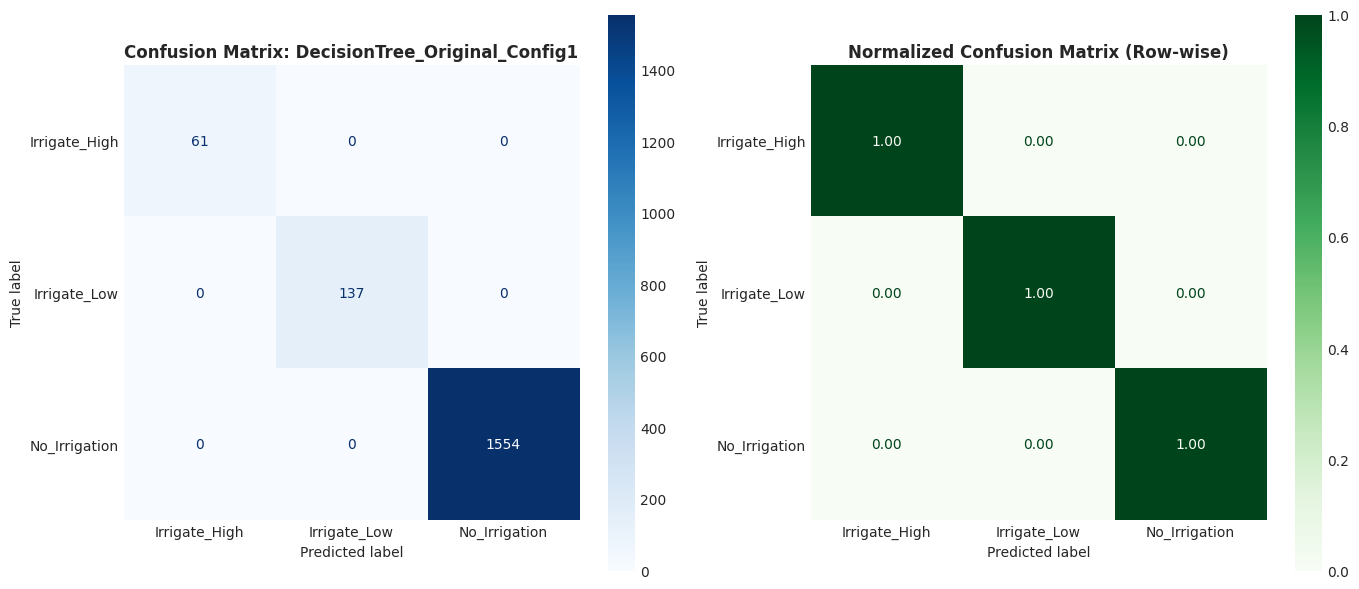


📊 Confusion matrices generated


In [19]:
# Plot confusion matrix for best model
best_model = best_model_result['model']
y_pred_best = best_model.predict(X_test)
cm_best = confusion_matrix(y_test, y_pred_best)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Raw confusion matrix
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=np.unique(y_test))
disp1.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title(f'Confusion Matrix: {best_model_result["model_name"]}', fontweight='bold', fontsize=12)
axes[0].grid(False)

# Normalized confusion matrix
cm_norm = cm_best.astype('float') / cm_best.sum(axis=1)[:, np.newaxis]
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=np.unique(y_test))
disp2.plot(ax=axes[1], cmap='Greens', values_format='.2f')
axes[1].set_title('Normalized Confusion Matrix (Row-wise)', fontweight='bold', fontsize=12)
axes[1].grid(False)

plt.tight_layout()
plt.show()

print("\n📊 Confusion matrices generated")

## 7. Feature Importance Analysis

### Understanding which features drive irrigation decisions

Analyzing feature importance...

TOP 20 MOST IMPORTANT FEATURES


,Feature,Importance,Importance_Pct
36,recent_rain,6.170553e-02,3.702332e+01
1,Atmospheric_Temp,6.118428e-02,3.671057e+01
3,Soil_Moisture,4.153301e-02,2.491981e+01
33,hour_cos,2.243842e-03,1.346305e+00
10,Soil_Moisture_rolling_std_12h,3.880391e-17,2.328235e-14
4,Dew_Point,0.000000e+00,0.000000e+00
2,Soil_Temp,0.000000e+00,0.000000e+00
0,Humidity,0.000000e+00,0.000000e+00
5,Soil_Moisture_rolling_mean_3h,0.000000e+00,0.000000e+00
8,Soil_Moisture_rolling_std_6h,0.000000e+00,0.000000e+00


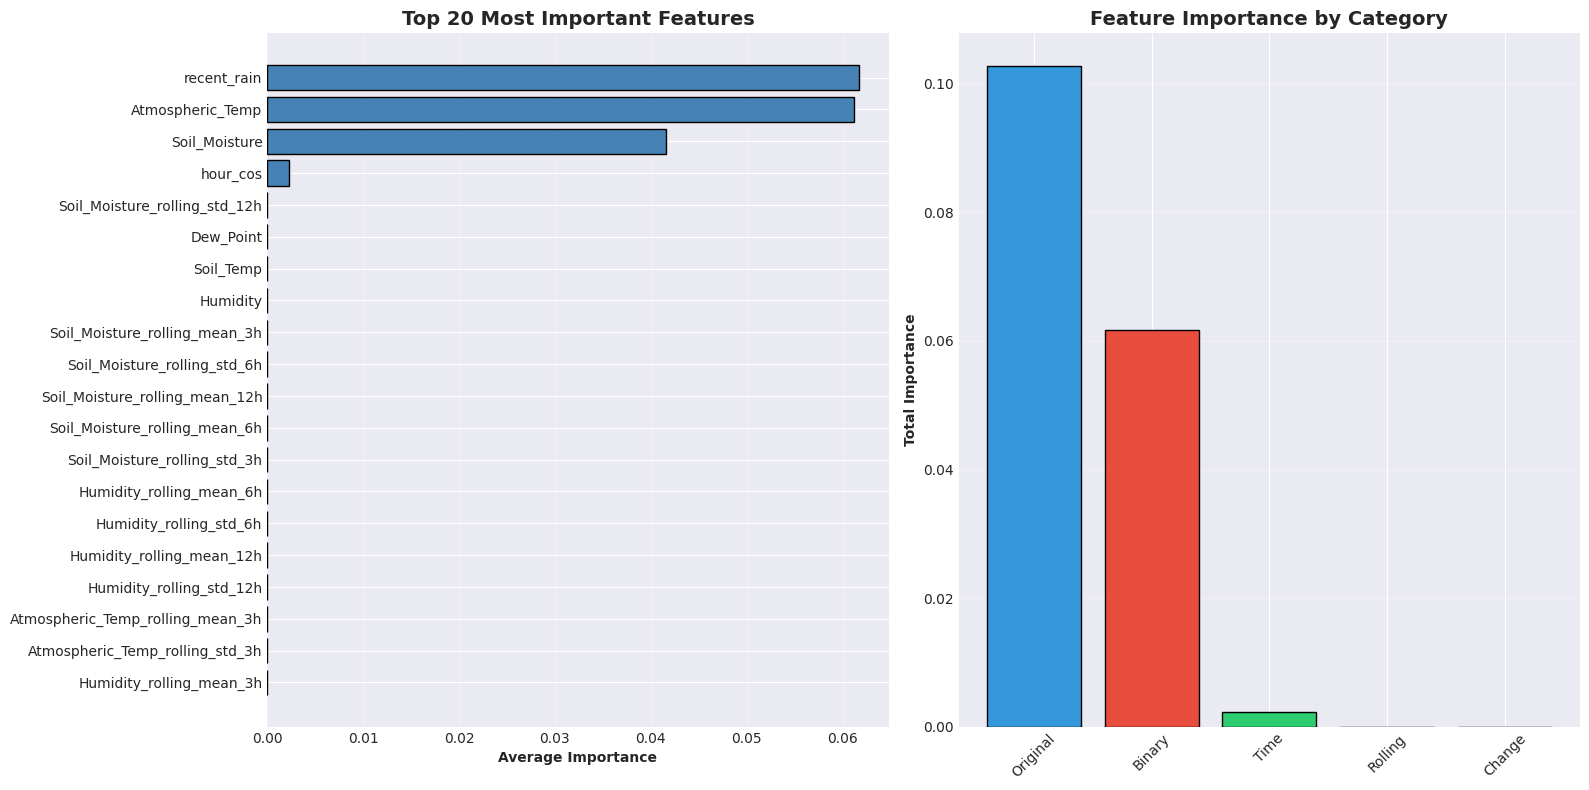


📊 Feature importance visualizations generated

💡 Key Insights:
   Top 3 features account for 98.65% of decisions
   Most important feature: recent_rain (37.02%)
   Most important category: Original


In [20]:
# Extract feature importance (tree-based models only)
if hasattr(best_model, 'feature_importances_'):
    print("Analyzing feature importance...\n")
    
    # Get feature importance (averaged across 6-hour window)
    feature_importance = best_model.feature_importances_
    
    # X_train_flat has shape (samples, window_size * num_features)
    # Reshape and average across time steps
    WINDOW_SIZE = 6
    num_base_features = len(feature_names)
    
    importance_matrix = feature_importance.reshape(WINDOW_SIZE, num_base_features)
    avg_importance = importance_matrix.mean(axis=0)
    
    # Create importance dataframe
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': avg_importance,
        'Importance_Pct': (avg_importance / avg_importance.sum() * 100)
    }).sort_values('Importance', ascending=False)
    
    print("="*80)
    print("TOP 20 MOST IMPORTANT FEATURES")
    print("="*80)
    display(importance_df.head(20))
    
    # Visualize top features
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Top 20 features
    top_20 = importance_df.head(20)
    axes[0].barh(range(len(top_20)), top_20['Importance'], color='steelblue', edgecolor='black')
    axes[0].set_yticks(range(len(top_20)))
    axes[0].set_yticklabels(top_20['Feature'])
    axes[0].set_xlabel('Average Importance', fontweight='bold')
    axes[0].set_title('Top 20 Most Important Features', fontweight='bold', fontsize=14)
    axes[0].invert_yaxis()
    axes[0].grid(True, alpha=0.3, axis='x')
    
    # Feature importance by category
    feature_categories = {
        'Original': ['Humidity', 'Atmospheric_Temp', 'Soil_Temp', 'Soil_Moisture', 'Dew_Point'],
        'Rolling': [f for f in feature_names if 'rolling' in f],
        'Change': [f for f in feature_names if 'change' in f],
        'Time': ['hour_of_day', 'day_of_week', 'hour_sin', 'hour_cos'],
        'Binary': ['is_daytime', 'is_yala_season', 'humidity_spike', 'recent_rain']
    }
    
    category_importance = {}
    for category, features in feature_categories.items():
        category_features = [f for f in features if f in feature_names]
        category_importance[category] = importance_df[
            importance_df['Feature'].isin(category_features)
        ]['Importance'].sum()
    
    cat_df = pd.DataFrame(list(category_importance.items()), columns=['Category', 'Total_Importance'])
    cat_df = cat_df.sort_values('Total_Importance', ascending=False)
    
    axes[1].bar(cat_df['Category'], cat_df['Total_Importance'], 
                color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6'], 
                edgecolor='black')
    axes[1].set_ylabel('Total Importance', fontweight='bold')
    axes[1].set_title('Feature Importance by Category', fontweight='bold', fontsize=14)
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    print("\n📊 Feature importance visualizations generated")
    
    # Log key insights
    print("\n💡 Key Insights:")
    print(f"   Top 3 features account for {importance_df.head(3)['Importance_Pct'].sum():.2f}% of decisions")
    print(f"   Most important feature: {importance_df.iloc[0]['Feature']} ({importance_df.iloc[0]['Importance_Pct']:.2f}%)")
    print(f"   Most important category: {cat_df.iloc[0]['Category']}")
    
else:
    print("⚠ Best model does not support feature importance (likely LogisticRegression)")
    importance_df = None

## 8. Save Best Model & Generate Training Log

In [ ]:
# Save best model
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_filename = f'irrigation_control_model_{timestamp}.pkl'
model_path = MODELS_DIR / model_filename

with open(model_path, 'wb') as f:
    pickle.dump(best_model, f)

print(f"✓ Best model saved to: {model_path}")

# Model size
model_size_mb = model_path.stat().st_size / (1024**2)
print(f"✓ Model size: {model_size_mb:.2f} MB")

# Generate comprehensive training log
training_log = {
    'timestamp': datetime.now().isoformat(),
    'model_info': {
        'model_type': best_model_result['model_name'].split('_')[0],
        'model_name': best_model_result['model_name'],
        'model_file': model_filename,
        'model_size_mb': float(model_size_mb),
        'hyperparameters': best_model_result['config'],
        'data_version': best_model_result['data_version']
    },
    'dataset_info': {
        'train_samples': int(len(y_train_versions[best_model_result['data_version']])),
        'test_samples': int(len(y_test)),
        'num_features': int(X_train.shape[1]),
        'num_classes': int(len(np.unique(y_train))),
        'class_distribution': {
            'train': {(k): (v) for k, v in pd.Series(y_train_versions[best_model_result['data_version']]).value_counts().items()},
            'test': {(k): (v) for k, v in pd.Series(y_test).value_counts().items()}
        },
        'preprocessing_metadata': preprocessing_metadata
    },
    'performance_metrics': {
        'train_accuracy': float(best_model_result['train_accuracy']),
        'test_accuracy': float(best_model_result['test_accuracy']),
        'test_precision_macro': float(best_model_result['test_precision_macro']),
        'test_recall_macro': float(best_model_result['test_recall_macro']), 
        'test_f1_macro': float(best_model_result['test_f1_macro']),
        'cv_accuracy_mean': float(best_model_result['cv_accuracy_mean']),
        'cv_accuracy_std': float(best_model_result['cv_accuracy_std']),
        'per_class_metrics': best_model_result['per_class_metrics'],
        'confusion_matrix': [[int(x) for x in row] for row in best_model_result['confusion_matrix']]
    },
    'efficiency_metrics': {
        'train_time_seconds': float(best_model_result['train_time']),
        'inference_time_ms_per_sample': float(best_model_result['inference_time_ms']),
        'edge_compatible': bool(best_model_result['inference_time_ms'] < 10),
    },
    'feature_importance': {
        'top_10_features': importance_df.head(10).to_dict('records') if importance_df is not None else None
    },
    'all_models_comparison': comparison_df.to_dict('records')
}

# Save training log
log_filename = f'training_log_{timestamp}.json'
log_path = LOGS_DIR / log_filename

with open(log_path, 'w') as f:
    json.dump(training_log, f, indent=2)

print(f"✓ Training log saved to: {log_path}")

✓ Best model saved to: /home/tehaan/projects/fyp-agro-edge-ai/models/irrigation_control_model_20251102_125502.pkl
✓ Model size: 0.00 MB
✓ Training log saved to: /home/tehaan/projects/fyp-agro-edge-ai/logs/irrigation_control/training_log_20251102_125502.json


## 9. Final Summary Report

In [22]:
print("="*80)
print("FINAL SUMMARY REPORT")
print("="*80)

print(f"\n🏆 Best Model Selected: {best_model_result['model_name']}")
print(f"\n📊 Performance Summary:")
print(f"   Test Accuracy:  {best_model_result['test_accuracy']*100:.2f}%")
print(f"   Test Precision: {best_model_result['test_precision_macro']*100:.2f}%")
print(f"   Test Recall:    {best_model_result['test_recall_macro']*100:.2f}%")
print(f"   Test F1-score:  {best_model_result['test_f1_macro']*100:.2f}%")
print(f"   CV Accuracy:    {best_model_result['cv_accuracy_mean']*100:.2f}% ± {best_model_result['cv_accuracy_std']*100:.2f}%")

print(f"\n⚡ Efficiency Metrics:")
print(f"   Training time:   {best_model_result['train_time']:.2f}s")
print(f"   Inference time:  {best_model_result['inference_time_ms']:.4f} ms/sample")
print(f"   Model size:      {model_size_mb:.2f} MB")
print(f"   Edge compatible: {'✓ YES' if best_model_result['inference_time_ms'] < 10 else '⚠ Borderline'}")

print(f"\n🔧 Hyperparameters:")
for key, value in best_model_result['config'].items():
    print(f"   {key}: {value}")

if importance_df is not None:
    print(f"\n💡 Top 5 Most Important Features:")
    for idx, row in importance_df.head(5).iterrows():
        print(f"   {row['Feature']}: {row['Importance_Pct']:.2f}%")

print(f"\n📁 Artifacts Saved:")
print(f"   Model:       {model_path}")
print(f"   Training log: {log_path}")

print("\n" + "="*80)
print("✓ Model comparison complete!")
print("="*80)

FINAL SUMMARY REPORT

🏆 Best Model Selected: DecisionTree_Original_Config1

📊 Performance Summary:
   Test Accuracy:  100.00%
   Test Precision: 100.00%
   Test Recall:    100.00%
   Test F1-score:  100.00%
   CV Accuracy:    99.90% ± 0.03%

⚡ Efficiency Metrics:
   Training time:   0.31s
   Inference time:  0.0016 ms/sample
   Model size:      0.00 MB
   Edge compatible: ✓ YES

🔧 Hyperparameters:
   max_depth: 10
   min_samples_split: 5
   criterion: gini

💡 Top 5 Most Important Features:
   recent_rain: 37.02%
   Atmospheric_Temp: 36.71%
   Soil_Moisture: 24.92%
   hour_cos: 1.35%
   Soil_Moisture_rolling_std_12h: 0.00%

📁 Artifacts Saved:
   Model:       /home/tehaan/projects/fyp-agro-edge-ai/models/irrigation_control_model_20251102_125502.pkl
   Training log: /home/tehaan/projects/fyp-agro-edge-ai/logs/irrigation_control/training_log_20251102_125502.json

✓ Model comparison complete!
